In [ ]:
import requests


def download_file_from_google_drive(id, destination):
    def get_confirm_token(response):
        for key, value in response.cookies.items():
            if key.startswith('download_warning'):
                return value

        return None

    URL = "https://docs.google.com/uc?export=download"
    session = requests.Session()
    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    CHUNK_SIZE = 32768
    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)

download_file_from_google_drive("1988xlZT2XimBlgOnvWokKv_ubwfXHHro", "./dataset.tar.gz")
!tar -xf dataset.tar.gz

In [ ]:
import numpy as np
import os
import cv2
from keras.utils import to_categorical
from keras.preprocessing.image import img_to_array


def get_data_x_and_y(data_path, width, height, depth, classes):
    """
    Essa função itera pelo data_path para separar dados como rotulos e
    os dados que serão utilizados para o treinamento e teste

    Args:
        data_path: O diretório com os dados
        width: Largura das matriz esperada pelo modelo
        height: Altura das matriz esperada pelo modelo
        classes: Numero de classes que o modelo utilizará

    Returns:
        Uma tupla onde na primeira posição você tem o eixo X e na segunda posição o eixo Y
    """
    print(f"Lendo arquivos de {data_path}...")
    labels = []
    data = []
    # itera pelo diretório
    for filename in os.listdir(data_path):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            # faz a leitura de cada imagem
            image = cv2.imread(os.path.join(data_path, filename))
            if depth == 1:
                image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            # redimensiona a imagem
            image = cv2.resize(image, (width, height))
            # converte a imagem para um vetor
            image = img_to_array(image)
            # concatena a imagem a lista de dados que serão utilizados pelo treinamento
            data.append(image)
            # concatena a lista de rotulos a classe da imagem
            labels.append(int(filename[5])-1)
            # print(filename)
    # Normaliza os dados de treinamento
    X = np.array(data, dtype="float32") / 255.0
    # Categoriza os rotulos
    Y = to_categorical(labels, num_classes=classes)
    print("Dataset carregado")
    return (X, Y)

In [ ]:
from keras.preprocessing.image import ImageDataGenerator


print("Preparando datasets...")
width = height = 140
depth = 3
classes = 2
(trainX, trainY) = get_data_x_and_y("./cats_and_dogs/train", width, height, depth, classes)
(testX, testY) = get_data_x_and_y("./cats_and_dogs/test", width, height, depth, classes)

aug = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode="nearest"
)

Preparando datasets...
Lendo arquivos de ./cats_and_dogs/train...
Dataset carregado
Lendo arquivos de ./cats_and_dogs/test...
Dataset carregado


In [ ]:
from keras.models import Sequential
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.core import Activation, Flatten, Dense, Dropout
from keras.layers.normalization import BatchNormalization


model = Sequential()

filter_size = 64
model.add(Conv2D(filters=filter_size, kernel_size=(3,3), padding="same",
                 activation='relu', input_shape=(width, height, depth)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

while filter_size <= 256:
    filter_size *= 2
    model.add(Conv2D(filters=filter_size, kernel_size=(3,3), activation='relu',
                     padding="same"))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Flatten())
model.add(Dense(1024, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(1024, activation="relu"))
model.add(Dropout(0.5))

model.add(Dense(classes))
model.add(Activation("softmax"))
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_22 (Conv2D)           (None, 140, 140, 64)      1792      
_________________________________________________________________
batch_normalization_22 (Batc (None, 140, 140, 64)      256       
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 70, 70, 64)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 70, 70, 128)       73856     
_________________________________________________________________
batch_normalization_23 (Batc (None, 70, 70, 128)       512       
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 35, 35, 128)       0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 35, 35, 256)      

In [ ]:
from keras.optimizers import SGD, Adam
from keras.callbacks import ModelCheckpoint


save_model = "vgg-{epoch:02d}-{acc:.3f}-{val_acc:.3f}.model"
epochs = 15
batch_size = 32

opt = Adam(lr=0.001)
# opt = SGD(lr=0.001, momentum=0.9)

model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["acc"])

checkpoint1 = ModelCheckpoint(save_model, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
checkpoint2 = ModelCheckpoint(save_model, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint1,checkpoint2]

H = model.fit_generator(aug.flow(trainX, trainY, batch_size=batch_size),
        validation_data=(testX, testY), steps_per_epoch=len(trainX) // batch_size,
        epochs=epochs, verbose=1,callbacks=callbacks_list)

Epoch 1/15
312/312 [==============================] - ETA: 0s - loss: 2.7944 - acc: 0.5485
Epoch 00001: val_loss improved from inf to 0.68381, saving model to vgg-01-0.549-0.567.model
INFO:tensorflow:Assets written to: vgg-01-0.549-0.567.model/assets

Epoch 00001: val_acc improved from -inf to 0.56700, saving model to vgg-01-0.549-0.567.model
INFO:tensorflow:Assets written to: vgg-01-0.549-0.567.model/assets
312/312 [==============================] - 100s 320ms/step - loss: 2.7944 - acc: 0.5485 - val_loss: 0.6838 - val_acc: 0.5670
Epoch 2/15
312/312 [==============================] - ETA: 0s - loss: 0.6890 - acc: 0.5871
Epoch 00002: val_loss improved from 0.68381 to 0.64734, saving model to vgg-02-0.587-0.636.model
INFO:tensorflow:Assets written to: vgg-02-0.587-0.636.model/assets

Epoch 00002: val_acc improved from 0.56700 to 0.63600, saving model to vgg-02-0.587-0.636.model
INFO:tensorflow:Assets written to: vgg-02-0.587-0.636.model/assets
312/312 [==============================] - 1

cat [1. 0.]


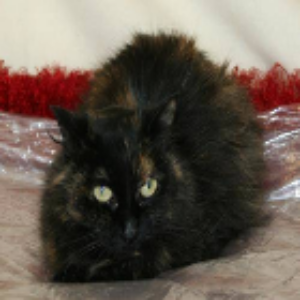

In [ ]:
from google.colab.patches import cv2_imshow

predictions = model.predict(testX)
result = ["cat" if cat > dog else "dog" for cat, dog in predictions]

index = 8
print(result[index], testY[index])
image = cv2.resize(testX[index]*255.0, (300, 300))
cv2_imshow(image)